In [1]:
"""
Inverse of Dft_combo :

The idea is to convert the 3D Dt distribution
using some given test values of H0 into Df distr.
and see how well it agrees with the 3D df distribution

""";


In [2]:
import os,sys
import matplotlib
import numpy as np
import corner,pickle
import json,copy,time
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from tools import *
from Dt_from_Df import *
from plot_H0 import plot_H0

In [3]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rc('figure',**{'figsize':(12,9)})
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [4]:
CP = 1

if CP:
    CP = "_CP"
else:
    CP = ""
res_dir = "./results/"
mkdir(res_dir)
# Df
df_resdir  = res_dir+"/Df_post"+CP+"/"

In [5]:
with open(df_resdir+"/Combined_PDF.pkl","rb") as f:
    PDF_Df = np.array(pickle.load(f))
with open(df_resdir+"/Combined_PDF_bins.pkl","rb") as f:
    PDF_Df_bins = np.array(pickle.load(f))
    
#Dt
#pycs_maindir = "/home/jackquei/Desktop/UNI_Muenchen/Thesis/steps/step4_lightcurves/Remastered/my_pycs_scripts/"
#sys.path.append(pycs_maindir)
#dt_resdir = pycs_maindir+"stnd_results_forcen/Combined/"
dt_resdir = res_dir+"/Dt_post/"
with open(dt_resdir+"/marginalisation_spline_sigma_0.50_combined.pkl","rb") as f:
    Dt_res = pickle.load(f)

#MOD_MULTIVAR
# we want to consider the error correlation, see notes 12th Nov.
cov_sys = (np.array(Dt_res.error.sys)**2)*np.identity(len(Dt_res.error.sys))
cov_rnd = np.cov(Dt_res.err_distr)
cov_dt  = cov_sys + cov_rnd
kwargs_dt = {"mean":Dt_res.results,"cov":cov_dt}
print("All data collected")

All data collected


$$ \large P (H_0)\ =\ \int d\Delta \phi P^{\text{lens model}}(\Delta \phi)* \frac{P^{\text{lightcurves}}(\Delta \phi (\Delta t)|H_0)}{\int dH_0 ' P^{\text{lightcurves}}(\Delta \phi (\Delta t)|H_0') }*Prior(H_0) $$

### What we want to obtain is:

$$ \large P (H_0)\ =\ \int\int\int d\Delta \phi_{AB}d\Delta \phi_{AC}d\Delta \phi_{BC} P_{\Delta \phi\  meas.}(\Delta \phi_{AB},\Delta \phi_{AC},\Delta \phi_{BC})* \frac{P_{\Delta t\ transf.}(\Delta \phi_{AB},\Delta \phi_{AC},\Delta \phi_{BC}|H_0)*Prior(H_0)}{\int dH_0 ' P_{\Delta t \  transf.}(\Delta \phi_{AB},\Delta \phi_{AC},\Delta \phi_{BC} | H_0') } $$

In [6]:
# Note: We will have to consider the density, but before we did the density in the fermat potential space,
# now we first convert to time delay space and then compute the density in the time delay space

In [7]:
def get_norm_density(distr_3D,d_bins=100): #d_bins would be interesting to optimise
    distr_3D_ = copy.deepcopy(distr_3D)
    try:
        np.shape(distr_3D_)[1:]==(3,) # shape must be (mc_i, 2)
    except:
        raise RuntimeError("Wrong shape of distr_3D: ",np.shape(distr_3D_)," must be (mc_i,3)")

    density,d_bins = np.histogramdd(distr_3D_,bins=d_bins,density=True) #density True return density function, not norm
    density_nrm = density/np.sum(density)
    return density_nrm,d_bins

def get_bin_center(bins):
    bins_centers = []
    for i in range(len(bins)):
        bins_centers_i = []
        for j in range(len(bins[i])-1):
            bins_centers_i.append((bins[i][j]+bins[i][j+1])/2.)
        bins_centers.append(bins_centers_i)
    bins_centers =np.array(bins_centers)
    return bins_centers

def get_analytic_density(mean,cov,bins):
    center_bins = get_bin_center(bins) 
    grid_of_points = np.transpose(np.meshgrid(*center_bins))
    dens  = multivariate_normal.pdf(grid_of_points,mean,cov)
    return dens


In [8]:
def get_PH0(n_bins=100,H0=np.arange(50,100,.1),
            Dt_kw = kwargs_dt,
            #Df    = mcmc_df,
            Dens_f = PDF_Df,
            nd_bins = PDF_Df_bins,
            other_ret=False):
    n_bins_ = copy.deepcopy(n_bins)
    # this is already done previously to combine the posteriors
    #Dens_f,nd_bins = get_norm_density(copy.deepcopy(Df),d_bins=n_bins_)
    
    PH0 = []
    for h0 in H0:
        kwargs_df = {"mean":Df_XY(copy.deepcopy(kwargs_dt["mean"]),h0),
             "cov":cov_Df(copy.deepcopy(kwargs_dt["cov"]),h0)}
        Dens_f_trsf = get_analytic_density(bins=copy.deepcopy(nd_bins),**kwargs_df)
        Dens_tot = copy.deepcopy(Dens_f)*Dens_f_trsf
        # the integration in this case is nothing else then the sum over every bin, ie:
        P_h0 = np.sum(Dens_tot)
        if np.isnan(P_h0):
            P_h0 = 0.
        PH0.append(P_h0)
    if np.sum(PH0)!=0:
        PH0 = PH0/np.sum(PH0)
    else:
        print("WARNING: sum of PH0 == 0")
    return np.array(PH0),H0


In [9]:

def get_analytic_density(mean,cov,bins,norm=1):
    center_bins = get_bin_center(bins) 
    grid_of_points = np.transpose(np.meshgrid(*center_bins))
    dens  = multivariate_normal.pdf(grid_of_points,mean,cov)*norm
    return dens


def get_normalisation(in_bins,Dt_kw,H0_range):
    bins = np.array(copy.deepcopy(in_bins))
    dH0 = H0_range[1]-H0_range[0] #is this necessary?
    kwargs_df = {"mean":Df_XY(copy.deepcopy(Dt_kw["mean"]),H0_range[0]),
     "cov":cov_Df(copy.deepcopy(Dt_kw["cov"]),H0_range[0])}
    norm = get_analytic_density(bins=bins,**kwargs_df)
    for i in range(1,len(H0_range)):
        kwargs_df = {"mean":Df_XY(copy.deepcopy(Dt_kw["mean"]),H0_range[i]),
             "cov":cov_Df(copy.deepcopy(Dt_kw["cov"]),H0_range[i])}
        norm+= get_analytic_density(bins=bins,**kwargs_df)*dH0
    print("normalisation done")
    return norm
def get_bin_vol(in_bins):
    bins =copy.deepcopy(in_bins)
    dim = np.shape(bins)[0]
    print(dim)
    bin_vol = 1
    for d in range(dim):
        bin_lenght=bins[d][1]-bins[d][0] 
        for n in range(5):
            rnd_index = np.random.randint(2,len(bins[d]))
            test_lenght =bins[d][rnd_index]-bins[d][rnd_index-1]
            if np.abs(bin_lenght-test_lenght)>1e-7:
                raise RuntimeError("Not all bins have the same size")
        bin_vol *= bin_lenght
    # we get a "volume" (vol in 3D, area in 2D, lenght in 1D) 
    # assuming that all bins are the same
    return bin_vol

def get_PH0_plot(n_bins=100,H0=np.arange(50,100,.1),
            Dt_kw = kwargs_dt,
            #Df    = mcmc_df,
            Dens_f = PDF_Df,
            nd_bins = PDF_Df_bins,
            other_ret=False,
            savefigs=False):
    n_bins_ = copy.deepcopy(n_bins)
    #Dens_f,nd_bins = get_norm_density(copy.deepcopy(Df),d_bins=n_bins_)
    
    PH0 = []
    Dens_f_trsf_norm = get_normalisation(in_bins=copy.deepcopy(nd_bins),\
                                             Dt_kw = copy.deepcopy(Dt_kw),\
                                             H0_range=H0)
    for h0 in H0:
        kwargs_df = {"mean":Df_XY(copy.deepcopy(Dt_kw["mean"]),h0),
             "cov":cov_Df(copy.deepcopy(Dt_kw["cov"]),h0)}
        
        
        Dens_f_trsf = get_analytic_density(bins=copy.deepcopy(nd_bins),\
                                           norm=Dens_f_trsf_norm,\
                                           **kwargs_df)
        
        Dens_tot = copy.deepcopy(Dens_f)*Dens_f_trsf
        # the integration in this case is nothing else then the sum over every bin, ie:
        Darea_bins = get_bin_vol(copy.deepcopy(nd_bins))
        P_h0 = np.sum(Dens_tot)*Darea_bins
        if np.isnan(P_h0):
            P_h0 = 0.
        PH0.append(P_h0)
        
    if np.sum(PH0)!=0:
        print("Evidence: ",np.sum(PH0))
        PH0 = PH0/np.sum(PH0)
    else:
        print("WARNING: sum of PH0 == 0")
    return np.array(PH0),H0

In [10]:
begin = time.time()
PH0,H0 = get_PH0()
print("Time passed: ",time.time()-begin)

Time passed:  2.046663999557495


In [11]:
os.system("say finished");

In [12]:
#plt.scatter(H0,PH0,marker=".")
#plt.ylim(0,max(PH0)*1.1)

with open(res_dir+"/ph0_results"+CP+".data","wb") as f:
    pickle.dump([PH0,H0],f)

In [13]:
### we want quantiles
qnt    = []
integr = 0
for i in range(len(PH0)):
    integr+=PH0[i]
    for qi in [0.16,.5,0.84]:
        if integr-PH0[i]<qi and integr>=qi:
            qnt.append(H0[i])

h0_res  = qnt[1]
err_min = qnt[1]-qnt[0]
err_max = qnt[2]-qnt[1]
print("analytical: ",np.round(h0_res,1),"+",np.round(err_max,1),"-",np.round(err_min,1)) 


analytical:  80.4 + 7.2 - 6.3


In [14]:
# planck  = 67.4 +- 0.5
h0planck = 67.4
h0planck_err = 0.5
h0licow  = 73.3 # km/s/Mpc
h0licow_err = [1.8,1.7]

In [15]:
with open(res_dir+"/ph0_results"+CP+".data","rb") as f:
    PH0,H0 = pickle.load(f)

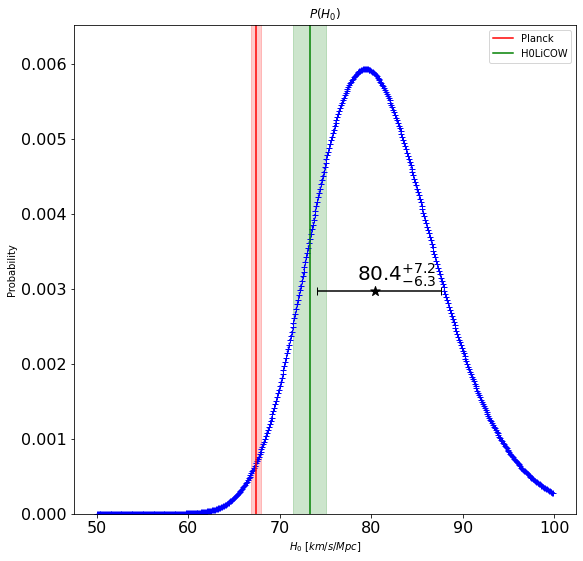

In [16]:
plot_H0(H0,PH0,figname=res_dir+"/PH0_dtf"+CP+".pdf",add_mode=False)

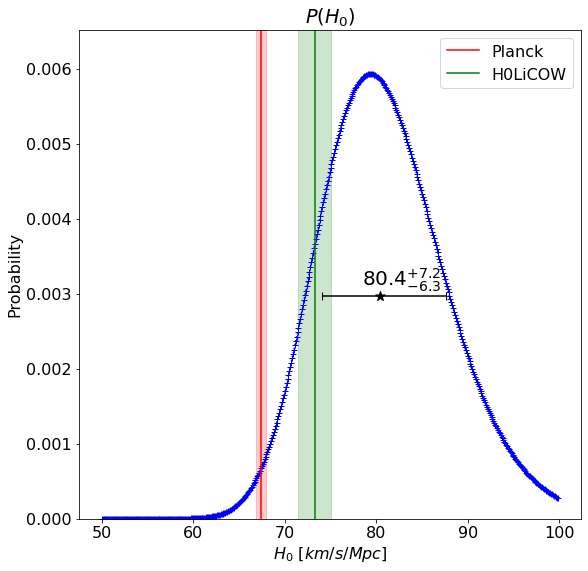

In [17]:
from importlib import reload 
import plot_H0
plot_H0 = reload(plot_H0)#.plot_H0
plot_H0 = plot_H0.plot_H0
#from plot_H0 import plot_H0
plot_H0(H0,PH0,figname=res_dir+"/PH0_dtf"+CP+".png",add_mode=False,transparent=False)